In [86]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from lab_processing import print_errors, create_plot

In [260]:
grad_neon = pd.read_csv('data/graduating_neon.tsv', sep='\t')
grad_hg = pd.read_csv('data/graduating_hg.tsv', sep='\t')
hydro = np.genfromtxt('data/hydrogen.tsv', delimiter='\t')
iodine = np.genfromtxt('data/iodine.tsv', delimiter='\t')

grad_neon.index = list(range(1, grad_neon.shape[0]+1))
grad_hg.index = ['K1', 'K2'] + [str(i) for i in range(1, 7)]

In [211]:
colibration_tex_columns = ['circ', 'lambda, Å']
# № &  $^\circ$ &  $\lambda$, Å \\

In [212]:
grad_neon_part1 = grad_neon.iloc[:13, :]
grad_neon_part2 = grad_neon.iloc[13:, :]

grad_neon_part1.to_latex('tables/neon_calibrating_part1.tex', column_format='lcr', header=colibration_tex_columns)
grad_neon_part2.to_latex('tables/neon_calibrating_part2.tex', column_format='lcr', header=colibration_tex_columns)
grad_hg.to_latex('tables/hg_calibrating.tex', caption='Градуировка на спектре ртути',
                 column_format='lcr', header=colibration_tex_columns)

## Градуировка

<AxesSubplot:xlabel='angle', ylabel='lambda'>

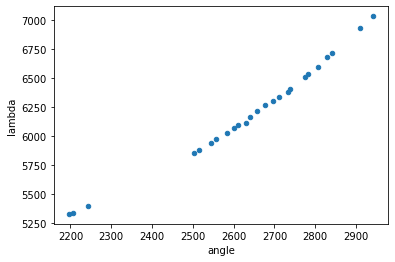

In [3]:
grad_neon.plot(x='angle', y='lambda', kind='scatter')

<AxesSubplot:xlabel='angle', ylabel='lambda'>

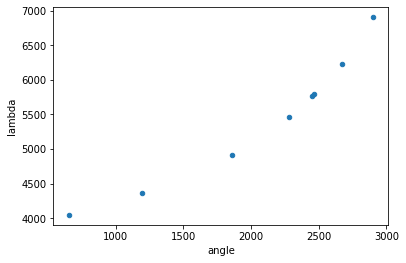

In [4]:
grad_hg.plot(x='angle', y='lambda', kind='scatter')

In [5]:
graduating_angle = np.hstack([grad_neon['angle'], grad_hg['angle']])
graduating_lambda = np.hstack([grad_neon['lambda'], grad_hg['lambda']])

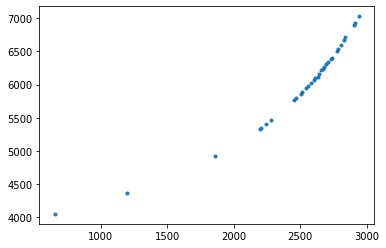

In [9]:
plt.scatter(graduating_angle, graduating_lambda, marker='.')

In [253]:
popt, pcov = np.polyfit(graduating_angle, graduating_lambda, deg=5, cov=True)

In [95]:
def format_func(value, tick_number):
    return f'{int(value)}$^\circ$'

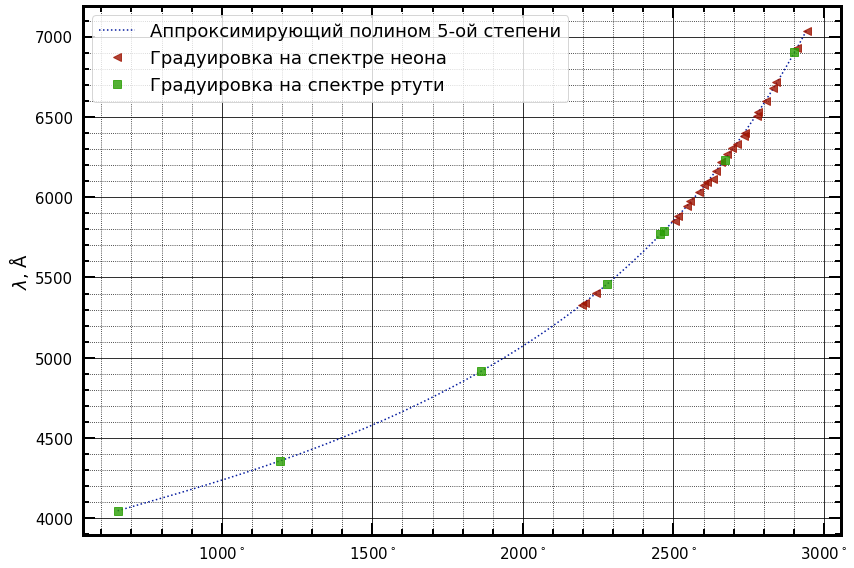

In [261]:
x = np.linspace(graduating_angle.min(), graduating_angle.max(), 5000)

fig, ax = create_plot(12, 8)

ax.plot(x, np.polyval(popt, x), linestyle=':', color='#02199e', label='Аппроксимирующий полином 5-ой степени')
ax.plot(grad_neon['angle'], grad_neon['lambda'], linestyle=' ', marker='<', alpha=0.8,
        markersize=8, c='#9e1402', label='Градуировка на спектре неона')
ax.plot(grad_hg['angle'], grad_hg['lambda'], linestyle=' ', marker='s', alpha=0.8,
        markersize=8, c='#299e02', label='Градуировка на спектре ртути')

ax.xaxis.set_major_formatter(plt.FuncFormatter(format_func))

# ax.set_xlabel('$^\circ$', fontsize=28)
# ax.set_title('График зависимости длины волны от делений барабана монохроматора', fontsize=18)
ax.set_ylabel('$\lambda$, Å', fontsize=18)
ax.legend(fontsize=18)

plt.tight_layout()

fig.savefig('graphs/calibrating.pdf')
fig.savefig('graphs/calibrating.png', dpi=300)

In [262]:
print_errors(popt, pcov)


    Final set of parameters             Asymptotic Standard Error
    =======================             =========================
    
    k5 = 3.64212339256104e-14		+/- 3.6437e-14 (100.0%)
    k4 = -2.35746769434068e-10		+/- 3.4643e-10 (147.0%)
    k3 = 6.95803100989864e-07		+/- 1.2563e-06 (180.6%)
    k2 = -0.000888386139832424		+/- 0.0021443 (241.4%)
    k1 =   1.03686388578842		+/- 1.6922 (163.2%)
    k0 =   3592.98643726698		+/- 483.67 (13.46%)



In [198]:
perr = np.sqrt(np.diag(pcov))
coeffs_df = pd.DataFrame({'coeffs': popt, 'abs_errors': abs(perr), 'rel_error': abs(perr/popt)})
coeffs_df.to_latex('tables/approx_coeffs.tex', index=False, label='tab:coeffs',
                   caption='Коэффициенты аппроксимирующего полинома')

In [290]:
sigma = (graduating_lambda - np.polyval(popt, graduating_angle)).std()
sigma

7.716171196400122

## Изучение спектров атома водорода

In [264]:
balmer = np.polyval(popt, hydro)
m_vec = np.arange(3, 7)
R_vec = 1/(balmer * (1/4 - 1/m_vec**2)) * 1e8
print(f'R_mean = {R_vec.mean()}', balmer, sep='\n')

R_mean = 109814.18451228962
[6554.42467464 4852.32271825 4338.63006339 4100.66383171]


In [265]:
balmer_eps = sigma / balmer
R_sigma = balmer_eps * R_vec
np.vstack([R_vec, R_sigma]).T

array([[109849.45830339,    129.31985158],
       [109912.9971976 ,    174.78382052],
       [109755.95273918,    195.19887817],
       [109738.32980899,    206.49333239]])

In [266]:
R_vec.std()

70.98074127715611

In [277]:
hydro_dict = {
    'grad': hydro,
    'lambda': np.round(balmer, 2), 
    'R': np.round(R_vec, 2),
    'sigma_r': np.round(R_sigma, 2),
}
hydro_df = pd.DataFrame(hydro_dict)
hydro_df.to_latex('tables/hydro_ridbergs.tex',
                  label='tab:ridbergs',
                  caption='Постоянная Ридберга, рассчитанная для разных спектральных линий водорода')

## Изучение молекулярного спектра йода

In [268]:
from scipy.constants import Planck as p, c, e

In [269]:
l0, l5, l_edge = np.polyval(popt, iodine)

In [279]:
hnu_10 = p * c / l0 * 1e10 / e
hnu_15 = p * c / l5 * 1e10 / e
hnu_edge = p * c / l_edge * 1e10 / e

hnu_10_sig = sigma / l0 * hnu_10
hnu_15_sig = sigma / l5 * hnu_15
hnu_edge_sig = sigma / l_edge * hnu_edge

In [284]:
hnu_2 = (hnu_15 - hnu_10) / 5
hnu_2_sig = 1/5(hnu_15_sig ** 2 + hnu_10_sig ** 2) ** 0.5

In [289]:
hnu_2_sig

0.0007240597276023204

In [272]:
hnu_1 = 0.027
E_a = 0.94

In [287]:
E_el = hnu_10 - 3/2 * hnu_2 + hnu_1 / 2
D_1 = hnu_edge - E_a
D_2 = hnu_edge - E_el

E_el_sig = (hnu_10_sig ** 2 + (3/2*hnu_2_sig) ** 2 + (0.001/2) ** 2) ** 0.5
D_1_sig = (hnu_edge_sig ** 2 + 0.01 ** 2) ** 0.5
D_2_sig = (hnu_edge_sig ** 2 + E_el_sig ** 2) ** 0.5

In [288]:
print((E_el, E_el_sig), (D_1, D_1_sig), (D_2, D_2_sig), sep='\n')

(1.9747536469786213, 0.002730094163165396)
(1.5120287344631298, 0.01067714651521483)
(0.4772750874845084, 0.004631940397621061)
